In [1]:
# imports
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind, permutation_test

In [16]:
# load data
training_set = pl.read_csv("../data/ARC_training_tasks.csv")
evaluation_set = pl.read_csv("../data/ARC_evaluation_tasks.csv")

In [17]:
def get_min_max(df, example_type):
    return (
        df.filter(pl.col("example_type") == example_type)
        .group_by("task_name")
        .agg(pl.max("example_number"))
        .select(
            pl.min("example_number").alias("min_examples"),
            pl.max("example_number").alias("max_examples"),
        )
        .row(0)
    )

In [18]:
# Get min and max number of training examples for both sets
train_min, train_max = get_min_max(training_set, "train")
eval_min, eval_max = get_min_max(evaluation_set, "train")

print(f"Training set:\n\tmin examples: {train_min}\n\tmax examples: {train_max}")
print(f"Evaluation set:\n\tmin examples: {eval_min}\n\tmax examples: {eval_max}")

Training set:
	min examples: 2
	max examples: 10
Evaluation set:
	min examples: 2
	max examples: 7


There are between 2 and 10 inference examples for training set tasks and 2 and 7 for evaluation set tasks.


In [19]:
# get min and max number of training examples on training/eval set for test examples
train_min, train_max = get_min_max(training_set, "test")
eval_min, eval_max = get_min_max(evaluation_set, "test")

print(f"Training set:\n\tmin examples: {train_min}\n\tmax examples: {train_max}")
print(f"Evaluation set:\n\tmin examples: {eval_min}\n\tmax examples: {eval_max}")

Training set:
	min examples: 1
	max examples: 3
Evaluation set:
	min examples: 1
	max examples: 2


There are between 1 and 3 test examples on the training set and 1 and 2 on the test set.


In [8]:
training_set_no_data_tests = (
    training_set.filter(pl.col("example_type") == "test")
    .group_by("task_name")
    .agg((pl.max("example_number") - 1).alias("missed_examples"))
    .filter(pl.col("missed_examples") > 0)
)
num_missed_training = training_set_no_data_tests.select(
    pl.sum("missed_examples")
).item()
evaluation_set_no_data_tests = (
    evaluation_set.filter(pl.col("example_type") == "test")
    .group_by("task_name")
    .agg((pl.max("example_number") - 1).alias("missed_examples"))
    .filter(pl.col("missed_examples") > 0)
)
num_missed_eval = evaluation_set_no_data_tests.select(pl.sum("missed_examples")).item()

print(
    f"We did not collect data for {num_missed_training} tests over {training_set_no_data_tests.height} tasks in the training set"
)
print(
    f"We did not collect data for {num_missed_eval} tests over {evaluation_set_no_data_tests.height} tasks in the evaluation set"
)

We did not collect data for 16 tests over 14 tasks in the training set
We did not collect data for 19 tests over 19 tasks in the evaluation set


In [20]:
def get_set_tests(dataset):
    # grid size
    filtered_tests = dataset.filter((pl.col("example_type") == "test")).with_columns(
        (pl.col("output_height") * pl.col("output_width")).alias("grid_size")
    )
    # number of examples per task
    num_examples_per_task = (
        dataset.filter(pl.col("example_type") == "train")
        .group_by("task_name")
        .agg(pl.max("example_number").alias("num_examples"))
    )
    filtered_tests = filtered_tests.join(num_examples_per_task, on="task_name")
    return filtered_tests

In [21]:
training_set_tests = get_set_tests(training_set)
training_set_tests = training_set_tests.with_columns(pl.lit("training").alias("set"))
evaluation_set_tests = get_set_tests(evaluation_set)
evaluation_set_tests = evaluation_set_tests.with_columns(
    pl.lit("evaluation").alias("set")
)
dataset = pl.concat([training_set_tests, evaluation_set_tests])

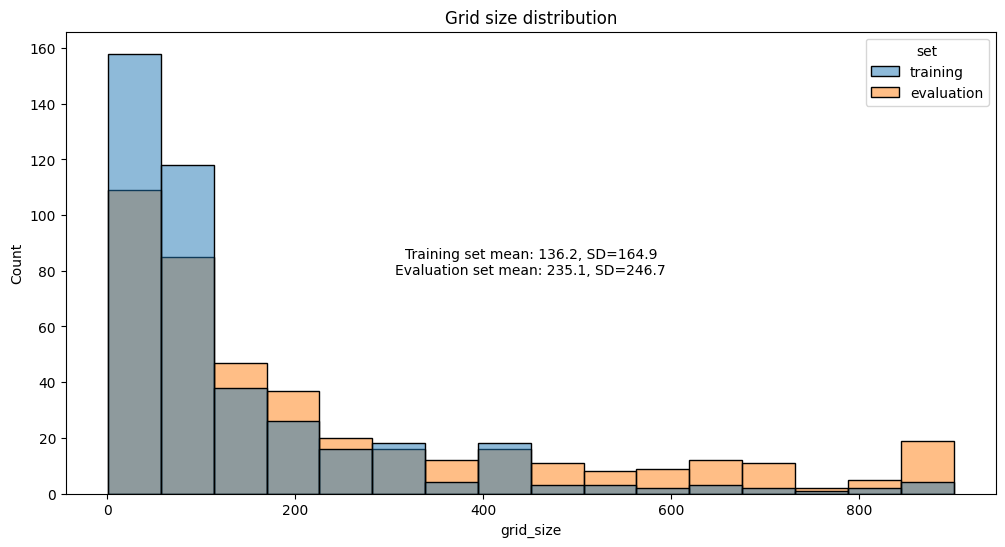

In [22]:
# plot grid size distribution
plt.figure(figsize=(12, 6))
sns.histplot(dataset, x="grid_size", bins=16, hue="set")
plt.title("Grid size distribution")
training_set_mean = training_set_tests.select(pl.mean("grid_size")).item()
evaluation_set_mean = evaluation_set_tests.select(pl.mean("grid_size")).item()
training_set_sd = training_set_tests.select(pl.std("grid_size")).item()
evaluation_set_sd = evaluation_set_tests.select(pl.std("grid_size")).item()
plt.text(
    0.5,
    0.5,
    f"Training set mean: {round(training_set_mean, 1)}, SD={round(training_set_sd, 1)}\nEvaluation set mean: {round(evaluation_set_mean, 1)}, SD={round(evaluation_set_sd, 1)}",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
)
plt.plot()
plt.show()

In [23]:
# run permutation test
training_set_grid_sizes = training_set_tests.select("grid_size").to_numpy().flatten()
evaluation_set_grid_sizes = (
    evaluation_set_tests.select("grid_size").to_numpy().flatten()
)

stats = ttest_ind(
    training_set_grid_sizes,
    evaluation_set_grid_sizes,
    equal_var=False,
)
print(f"Test statistic: {stats.statistic}")
print(f"P-value: {stats.pvalue}")
print(f"Degrees of freedom: {stats.df}")

Test statistic: -6.81421447779164
P-value: 1.9843266953504276e-11
Degrees of freedom: 730.1473878533382


Permutation tests show that output grid sizes are significantly smaller in the training set than in the evaluation set (p < .001).


In [24]:
dataset.write_csv("../data/ARC_all_tasks_tests_stats.csv")